# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 15 ("                               'fc4f30', ")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 16 ("                               'e5ae38',")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 17 ("                               '6d904f',")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 18 ("                               '8b8b8b',")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 19 ("                               '810f7c'])")
Bad value in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 14 ("axes.prop_cycle: cycler(color=['008fd5', "): Key axes.prop_cycle: 'cycler(color=['008fd5',' is not a valid cycler construction: unexpected EOF while parsing (<unknown>, 

In [2]:
import matplotlib as mpl

In [3]:
import seaborn as sns

# Load Data & Clean

In [4]:
alc = pd.read_csv("data/alc_sales.csv")

alc.index = pd.to_datetime(alc.DATE)     # convert indes into Datetime 

alc.drop(columns=["DATE", "MRTSSM4453USS_20220216"], inplace=True)    # drop unnecessary columns 

alc.index.rename("Date", inplace=True)   # rename the index 

alc.columns = ["Sales"]      # rename the columns - here it's just first one

alc.replace(".", np.nan, inplace=True)   # replace "." with np.nan to interpolate in a next step

# interpolate missing values (np.nan) forward (that is, going down) along each column using linear interpolation.
alc["Sales_inter"] = alc["Sales"].astype(float).interpolate(method='linear', limit_direction='forward', axis=0)

In [5]:
alc   # Note, in the series, the ‘Sales/Sales_inter’ columns are placed higher than Date to imply that it is a series.

,Sales,Sales_inter
Date,,
1992-01-01,1713,1713.0
1992-02-01,1763,1763.0
1992-03-01,1753,1753.0
1992-04-01,1784,1784.0
1992-05-01,1783,1783.0
...,...,...
2021-08-01,5854,5854.0
2021-09-01,5839,5839.0
2021-10-01,5846,5846.0


In [6]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(10,4), dpi=dpi)
    plt.plot(x, y, color='tab:green')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

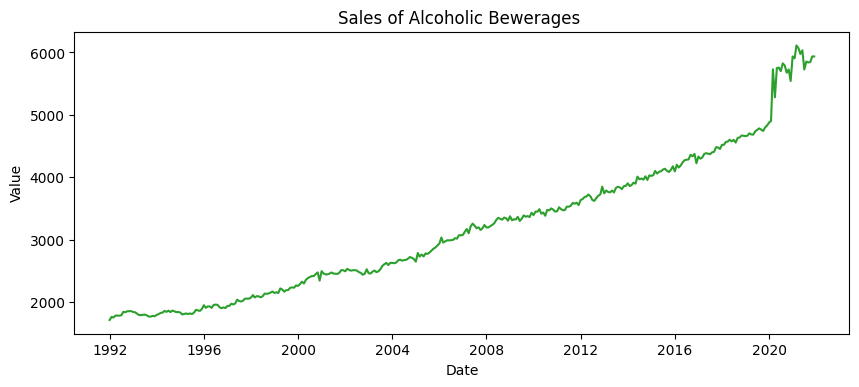

In [7]:
plot_df(alc, x=alc.index, y=alc.Sales_inter, title='Sales of Alcoholic Bewerages ')    

# Baseline 

## Simple Baseline 
the most simple forecast is the prediction of a value equal to the value before

In [8]:
drugs = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
drugs.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


### Simple Model R2 score

- The R2 score is one of the performance evaluation measures for regression-based machine learning models. 
- It is also known as the coefficient of determination. 
- It measures the amount of variance in the predictions explained by the dataset resp. difference between the samples in the dataset and the predictions made by the model.
- If the value of the R2 is 1, it means that the model is perfect and if its value is 0, it means that the model will perform badly on an unseen dataset.

In [9]:
from sklearn.metrics import r2_score
#  the predicted value is just the from the month before
y_pred = drugs.value.shift(1).dropna()
# drop the first (last in line) value because we have no prediction for it
y_true = drugs.value[1:]
# r_score as a quality measure for prediction
print(f"R2: {(r2_score(y_true, y_pred)).round(4)}")

R2: 0.8578


## Baseline Model with 12 auto-regressive features X

### Train-Test-Split

In [12]:
#  60% to train 40% for testing
drugs2 = drugs.copy() 
train_size = 0.6
index = round(train_size*drugs.shape[0])
drugs_train = drugs2.iloc[:index]
drugs_test = drugs2.iloc[index:]

drugs_train = drugs_train.copy()
drugs_test = drugs_test.copy()

# the current value now has 12 features, consisting of it's predecessing values 
for i in range(1, 13):
    drugs_train[f't - {i}'] = drugs_train.value.shift(i)
    drugs_test[f't - {i}'] = drugs_test.value.shift(i)

drugs_train.dropna(inplace=True)    
drugs_test.dropna(inplace=True)    

# the table now starts 12 month later bc. we use 12 months as input features for or our prediction
drugs_train.head(3)

In [16]:
# trainig data consist of the 12 features - every column of the df  is read as a feature 
# t-1 to t-12 are now  features for every row
X2_train = drugs_train.drop(columns = ['value'])
X2_train.head(3)

,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12
date,,,,,,,,,,,,
1992-07-01,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003,3.252221,3.180891,3.526591
1992-08-01,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003,3.252221,3.180891
1992-09-01,3.558776,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003,3.252221


In [19]:
# the target of the (autio regression) is the actual value
y2_train = drugs_train.value

In [20]:
# the same goes for the test data
X2_test = drugs_test.drop(columns = ['value'])
y2_test = drugs_test.value

print(X2_train.shape, y2_train.shape, X2_test.shape, y2_test.shape)

(110, 12) (110,) (70, 12) (70,)


### Train the AR model

In [21]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# train a linear regression model with the training data
model = model.fit(X2_train, y2_train)

### Measure R2

In [23]:
# quality of the model when tested with new data
r2_score(y2_test, model.predict(X2_test))

0.858087454886376

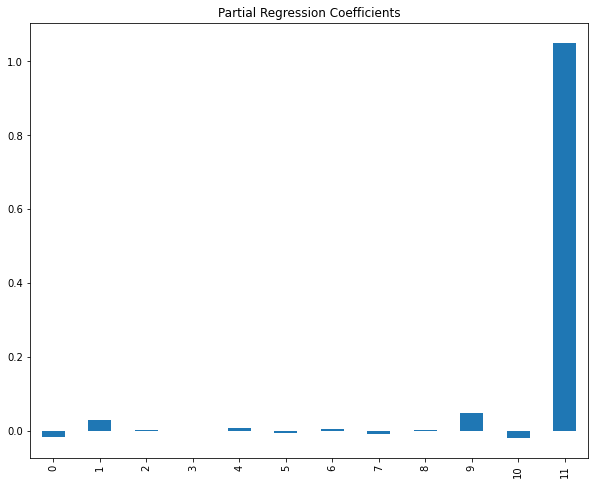

In [24]:
# to what extent do the 12 auto-regressive features explain the actual value
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 8));
pd.Series(model.coef_).plot(kind='bar');
plt.title('Partial Regression Coefficients');

# Seasonal Plot of a Time Series

In [68]:
# Prepare data
drugs['year'] = [d.year for d in drugs.index]    # extract years of a every date
drugs['month'] = [d.strftime('%b') for d in drugs.index]   # extract month of all dates
years = drugs['year'].unique()  # get all the unique years

In [26]:
# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

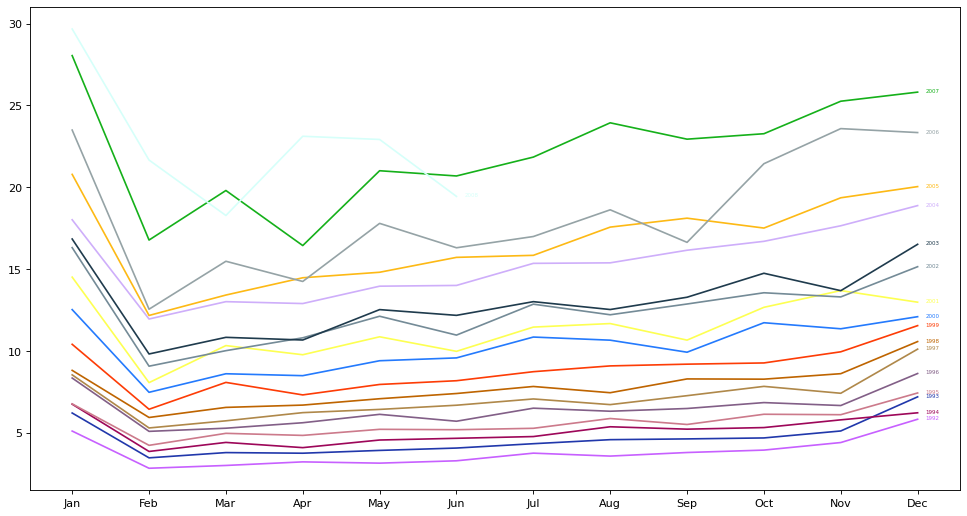

In [31]:
# Draw Plot
plt.figure(figsize=(15,8), dpi= 80)

for i, y in enumerate(years):
        if i > 0:        
            plt.plot('month', 'value', data=drugs.loc[drugs.year==y, :], color=mycolors[i], label=y)
            plt.text(drugs.loc[drugs.year==y, :].shape[0]-.9, drugs.loc[drugs.year==y, 'value'][-1:].values[0], y, fontsize=5, color=mycolors[i])

# Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution

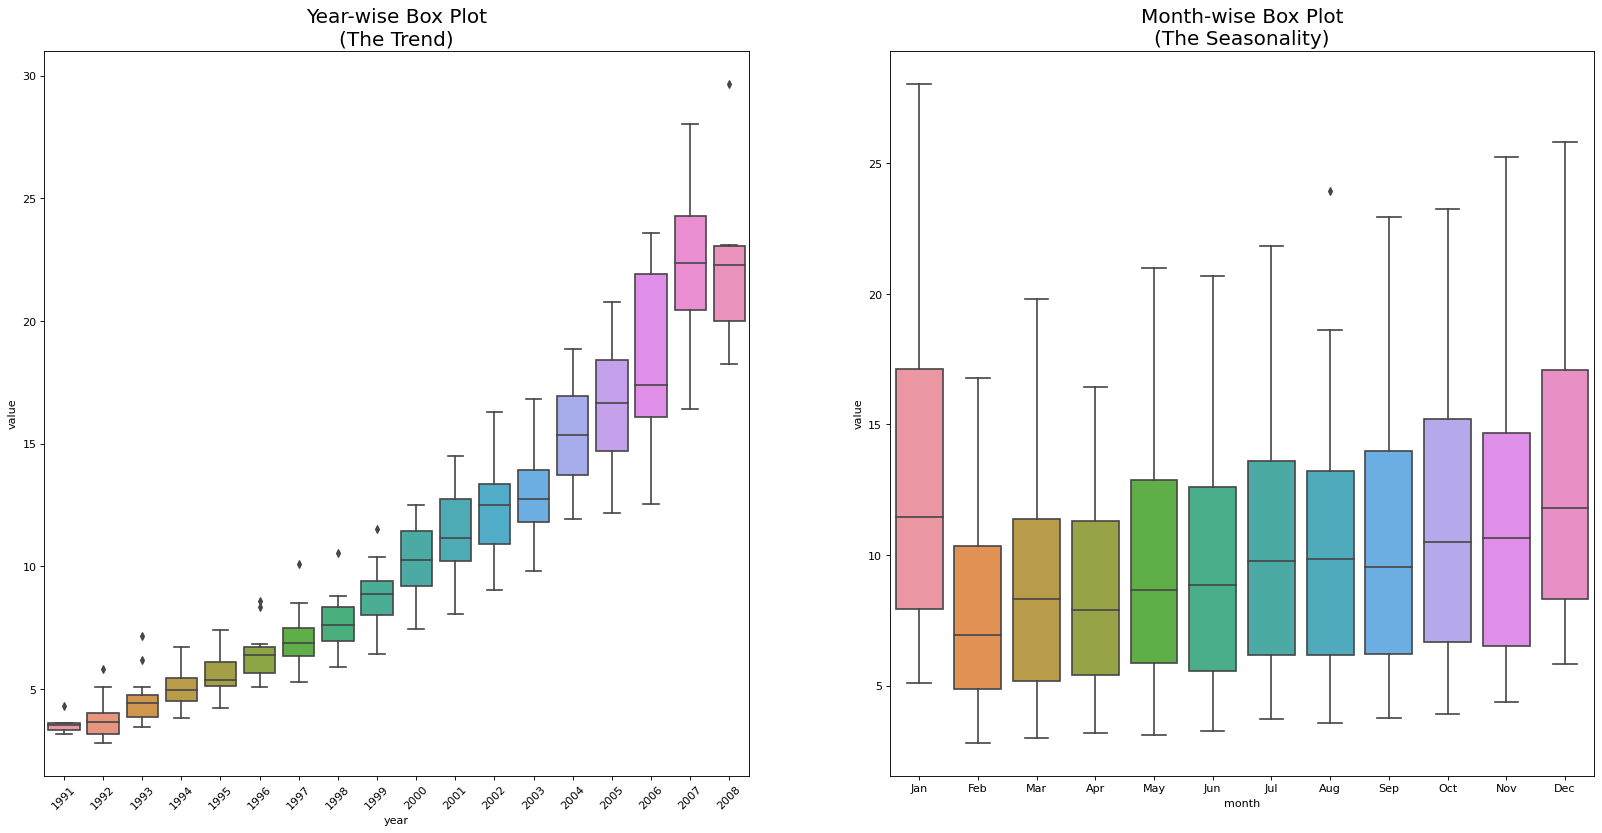

In [32]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(25,12), dpi= 80)
sns.boxplot(x='year', y='value', data=drugs, ax=axes[0])
sns.boxplot(x='month', y='value', data=drugs.loc[~drugs.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)

plt.show()

# Patterns in a time series
Any time series may be split into the following components: **Base Level + Trend + Seasonality + Error**

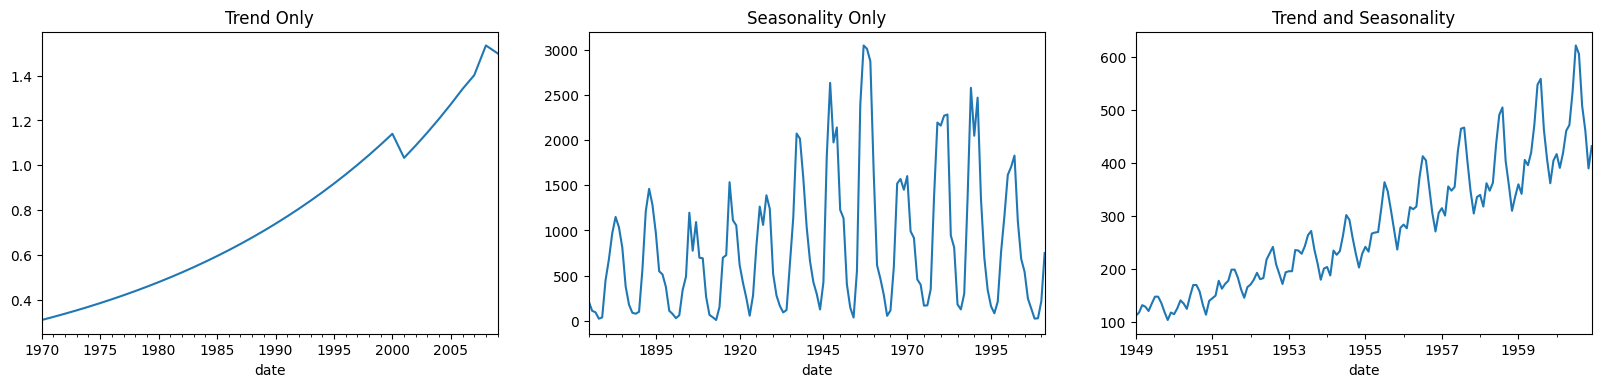

In [33]:
fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0]);
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1]);
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2]);
plt.show()

Care should be taken to not confuse ‘cyclic’ effect with ‘seasonal’ effect. So, How to diffentiate between a **‘cyclic’ vs ‘seasonal’** pattern? If the patterns are not of fixed calendar based frequencies, then it is cyclic. Because, unlike the seasonality, cyclic effects are typically influenced by the business and other socio-economic factors.

# Decompose a time series into its components

## Additive and multiplicative time series
**Additive** TS: Value = Base Level + Trend + Seasonality + Error </br>
**Multiplicative** TS: Value = Base Level $\times$ Trend $\times$ Seasonality $\times$ Error

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

Setting **extrapolate_trend='freq'** takes care of any missing values in the trend and residuals at the beginning of the series.

In [35]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(drugs['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(drugs['value'], model='additive', extrapolate_trend='freq')

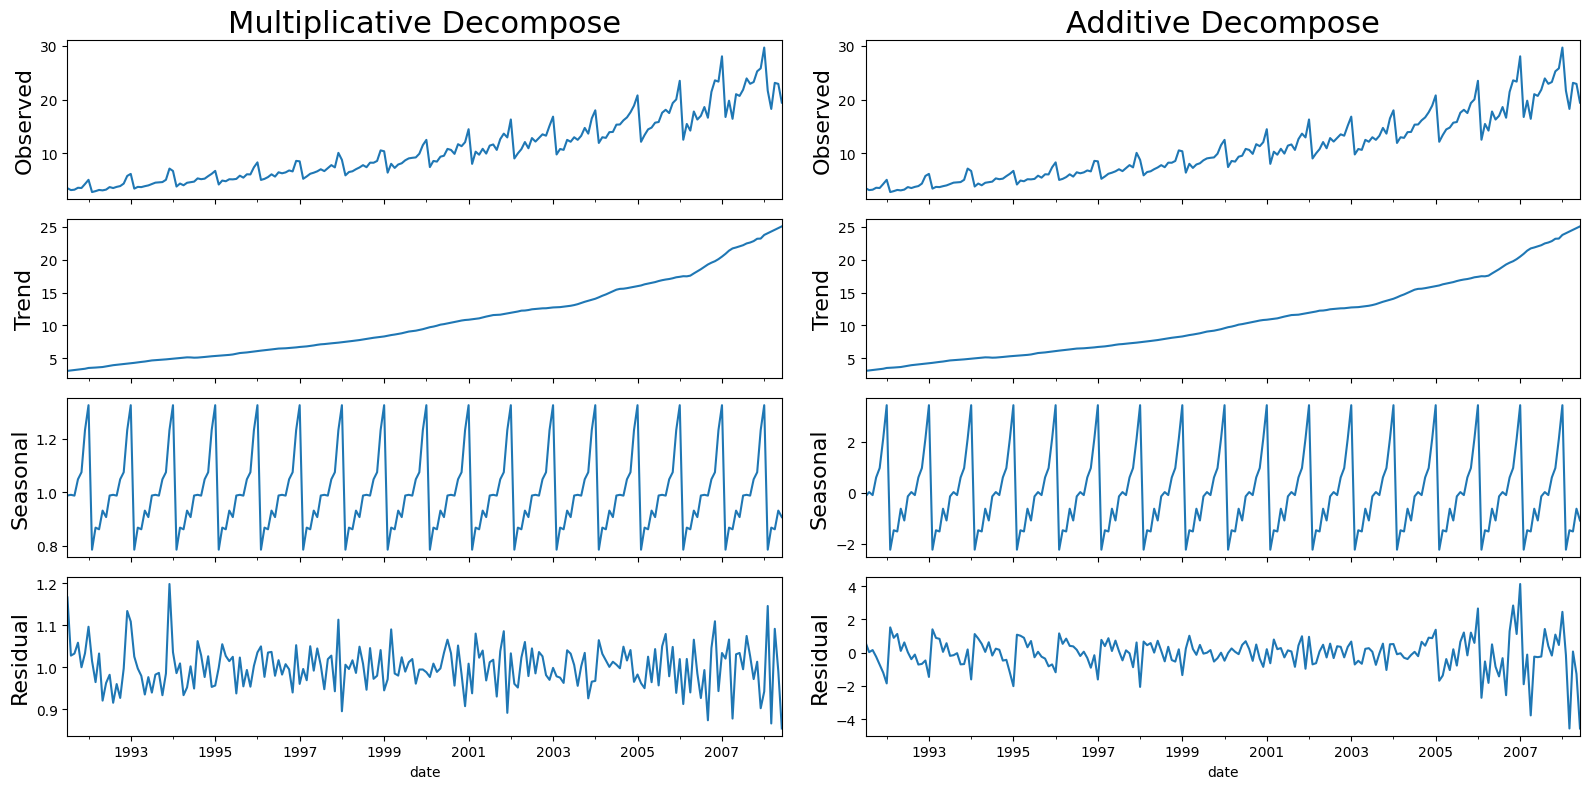

In [36]:
# Plot
def plotseasonal(res, axes, title):
    axes[0].set_title(title, fontsize=22)
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed', fontsize=16)
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend', fontsize=16)
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal', fontsize=16)
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual', fontsize=16)

    
fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8), dpi=100)
plotseasonal(result_mul, axes[:,0], title="Multiplicative Decompose")
plotseasonal(result_add, axes[:,1], title="Additive Decompose")


plt.tight_layout()
plt.show()


If you look at the residuals of the **additive decomposition** closely, it has some **pattern left over**. The multiplicative decomposition, however, looks quite random (stationary) which is good. So ideally, **multiplicative decomposition should be preferred for this particular series**. The numerical output of the trend, seasonal and residual components are stored in the result_mul output itself. Let’s extract them and put it in a dataframe.

## Extract  Decomposition  Components

In [37]:
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seasonal', 'trend', 'residuals', 'actual_values']
df_reconstructed.head()

,seasonal,trend,residuals,actual_values
date,,,,
1991-07-01,0.987845,3.060085,1.166629,3.526591
1991-08-01,0.990481,3.124765,1.027745,3.180891
1991-09-01,0.987476,3.189445,1.032615,3.252221
1991-10-01,1.048329,3.254125,1.058513,3.611003
1991-11-01,1.074527,3.318805,0.999923,3.565869


In [38]:
round(0.987845*3.060085*1.166629, 6)

3.526591

# Stationary and Non-Stationary Time Series

Forecating models work best when TS do not exhibit meaningful statistical changes over time
(so that we can capture these statistical properties and prolongate them in the future)
In time series we call this **stationarity**.

- **A stationary series is one where the values of the series is not a function of time.** </br>
- That is, the statistical properties of the series like **mean, variance and autocorrelation <u>are constant</u> over time.**</br>
- **Autocorrelation** of the series is nothing but the **correlation of the series with its previous values.** </br>
- A stationary time series is devoid of seasonal effects as well. </br>
- We can slice up stationary TS into equally sized chunks and still get the same probability distribution.
- Stationarity refers to a random process that has constant statistical properties through time. </br> 
This matters because it means that the process creates a predictable distribution.

**To Forecast:**
1.  First, convert a non-stationary series to stationary.
2.  Then, forecast stationary TS by prolongating stationary properties
3.  Finally reintroduce seasonality & trend etc.

**How do we test for stationarity?**
1. Visually
2. Calculate (mean, variance, and autocorrelation) in various intervals
3. Augmented Dickey Fuller - ADF Test (p-values)

In [ ]:
from IPython.display import Image
Image(url= "station.png", width=1000, height=1000)

## Make a time series stationary
by: 
- **Differencing** the Series (once or more)
- Decomposition 
- Transformations
    * take the **log** of the series
    * take the nth **root** of the series
- Combinations of the above

The most common and convenient method to stationarize the series is by **differencing** the series at least once until it becomes approximately stationary. So what is differencing? If $Y_t$ is the value at time ‘$t$’, then the first difference of $Y$ = $Y_t$ – $Y_{t-1}$.

- Forecasting a stationary series is relatively easy and the forecasts are more reliable. 
- An important reason is, **autoregressive forecasting models are essentially linear regression models** that utilize the lag(s) of the series itself as predictors. We know that **linear regression works best if the predictors (X variables) are not correlated** against each other. So, **stationarizing** **removes any persistent autocorrelation** in the series, thereby making the predictors (lags of the series) in the forecasting models nearly independent.

## How to test for stationarity?

The stationarity of a series can be established by looking at the plot of the series like we did earlier. </br>
Another method is to split the series into 2 or more contiguous parts and computing the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary. 

Methods to quantitatively determine if a given series is stationary or not are called ‘**Unit Root Tests**’. Where the tests check if a time series is non-stationary and possess a unit root. There are multiple implementations of Unit Root tests like:

* **Augmented Dickey Fuller test (ADH Test)**
* Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
* Philips Perron test (PP Test)

- The most commonly used is the **ADF test**
    - $H_0$: is not-stationary & has unit root</br> 
    - $H_1$:  is stationary & no unit root</br> 
    
So, if the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis. 


- The **KPSS test**, on the other hand, is used to test for trend stationarity.  </br>
    - $H_0$: stationary 
    - $H_1$: non-stationary

### P-Value
-  a p-value close to 0 (e.g. p < $\alpha$ (0.005)) indicates stationarity.
- The **p-value**, tells you how likely it is that your data could have occurred under the null hypothesis.
- The significance level $\alpha$ is outside the confidence intervall, where we reject the $H_0$ hypothesis. 
- If p (probability that our test statistic occured under the $H_0$) is even smaller than $\alpha$, then we can reject $H_0$ with confidence, because it says that the test statistic is very unlikely.
- the p-value is the lowest significance level α that results in rejecting the null hypothesis.
- The smaller the p-value, the more likely you are to reject the null hypothesis.
- If we have a p-value of 1,9% we can choose a significance level $\alpha$ of 2% at which the $H_0$ can be rejected.
- Thus we can use the p-values to make comparisons between different test statistics.

**Pitfalls**
- P-values are often interpreted as your risk of rejecting the null hypothesis of your test when the null hypothesis is actually true.
- In reality, **the risk of rejecting the null hypothesis is often higher than the p-value**, especially when looking at a single study or when using small sample sizes. This is because the smaller your frame of reference, the greater the chance that you stumble across a statistically significant pattern completely by accident.
- P-values are also often interpreted as supporting or refuting the alternative hypothesis. This is not the case. **The p-value can only tell you whether or not the null hypothesis is supported.** It cannot tell you whether your alternative hypothesis is true, or why.

### Augmented Dickey Fuller - ADF Tests
- H<sub>0</sub>: The series is not-stationary. || p-value close to 0 (e.g. p < 0.05) indicates stationarity.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
result = adfuller(drugs.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

Unlike KPSS test, the null hypothesis in ADF test is the series is not stationary. Since p-value is well above the 0.05 alpha level, you cannot reject the null hypothesis. So the series is NOT stationary according to ADF test, which is actually expected.

ADF Test:</br> 
- $H_0$: is not-stationary & has unit root</br> 
- $H_1$:  is stationary & no unit root</br> 

ADF Returns:
- adffloat: The test statistic.
- pvaluefloat: MacKinnon’s approximate p-value based on MacKinnon (1994, 2010).
- usedlagint: The number of lags used.
- nobsint: the number of observations used for the ADF regression and calculation of the critical values.
- critical valuesdict: Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).

### KPSS Test

In [ ]:
result = kpss(drugs.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

The output of the KPSS test contains 4 things:

- KPSS statistic
- p-value
- Number of lags used by the test
- Critical values

* We reject $H_0$ -> NOT stationary if:
    - p-value < alpha level (typically 0.05)
* KPSS statistic: to reject $H_0$:
    - test statistic > critical values. 

If test statistic > critical value -> low p-value

Difference between KPSS and ADF: **KPSS tests for stationarity of the series around a ‘deterministic trend’**. 

That means that the test may not necessarily reject the null hypothesis (that the series is stationary) even if a series is steadily increasing or decreasing. 

**Deterministic trend**: slope of the trend in the series does not change permanently. That is, even if the series goes through a shock, it tends to regain its original path. 
* Deterministic Trends: These are trends that consistently increase or decrease.
* Stochastic Trends: These are trends that increase and decrease inconsistently.

* The deterministic trend is one that you can determine from the equation directly, for example for the time series process $y_t = c_t + ε$ has a deterministic trend with an expected value of $E[y_t] = c_t$ and a constant variance of  $Var (y_t) = σ^2$ (with $ε − iid ( 0, σ^2)$. 
* A deterministic trend is obtained using the regression model $y_t=β_0+β_1t+η_t$  where $η_t$ is an ARMA process.
* A deterministic system is a system in which no randomness is involved in the development of future states of the system. 

If the test says the p-value is significant (with p_value < 0.05) and hence, you can reject the $H_0$ -> series is NOT stationary ($H_1$) . 

But we thought the KPSS should not have rejected the null, because of the ‘stationarity around a deterministic trend’. Yes? Well, that’s probably because we used the default option of the KPSS test. **By default, it tests for stationarity around a ‘mean’ only.**

In KPSS test, **to turn ON the stationarity testing around a trend**, you need to explicitly pass the **regression='ct'** parameter to the kpss.

- “c” : The data is stationary around a constant (default).
- “ct” : The data is stationary around a trend.

Now if the p-value is so high that you cannot reject the null hypothesis, the series is stationary. 

**Conclusion**

So overall what this means to us is, if a series is stationary according to the KPSS test by setting regression='ct' and is not stationary according to the ADF test, it means the series is stationary around a deterministic trend and so is fairly easy to model this series and produce fairly accurate forecasts. 

# Difference between white noise and a stationary series

- Like a stationary series, the white noise is also not a function of time, that is its mean and variance does not change over time.
- But the difference is, the **white noise is completely random with a mean of 0**. In white noise there is no pattern whatsoever. 


In [ ]:
plt.figure(figsize=(8,6))
randvals = np.random.randn(1000);
pd.Series(randvals).plot(title='Random White Noise', color='grey');

# Detrend a TS

Detrending a time series is to remove the trend component from a time series. 
- **Subtract the line of best fit** from the TS. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms ($x^2$) in the model.
- **Subtract the trend component** obtained from time series decomposition we saw earlier.
- **Subtract the mean**
- **Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter** (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

## Subtract the line of best fit - Using scipy

In [39]:
from scipy import signal
detrended_bestfit = signal.detrend(drugs.value.values)

## Subtracting the Trend Component - Using statmodels

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul2 = seasonal_decompose(drugs['value'], model='multiplicative', extrapolate_trend='freq')
detrended_subtract = drugs.value.values - result_mul.trend

## Detrending by taking the Logarithmus

In [41]:
import numpy as np
detrended_log = np.log(drugs.value.values)

In [42]:
detrend_array = np.array([detrended_bestfit, detrended_subtract, detrended_log])
detrend_df = pd.DataFrame(detrend_array.T, columns = ['detrended_bestfit','detrended_subtract','detrended_log'], index=drugs.index)

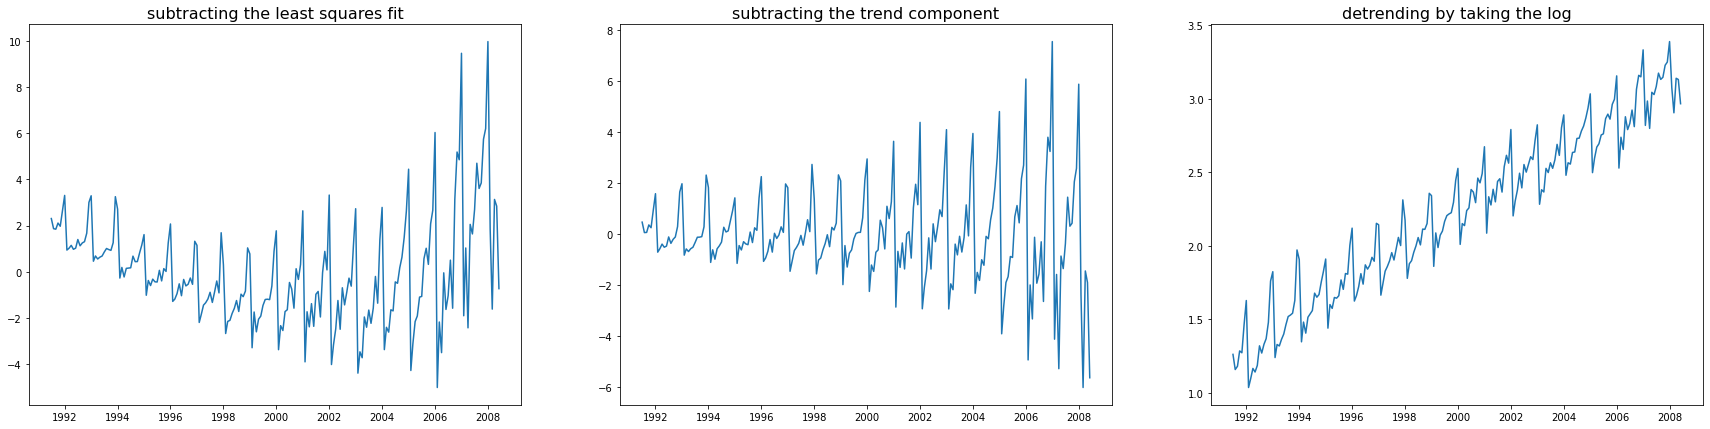

In [43]:
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, figsize=(30,7))
axes[0].plot(detrend_df.detrended_bestfit)
axes[0].set_title('subtracting the least squares fit', fontsize=16);

axes[1].plot(detrend_df.detrended_subtract)
axes[1].set_title('subtracting the trend component', fontsize=16);

axes[2].plot(detrend_df.detrended_log)
axes[2].set_title('detrending by taking the log', fontsize=16);


## Detrend by Differencing
Another way to detrend time series data is to simply create a new dataset where each observation is the difference between itself and the previous observation.

In [44]:
differenced_1 = drugs.value.diff()
differenced_2 = differenced_1.diff()

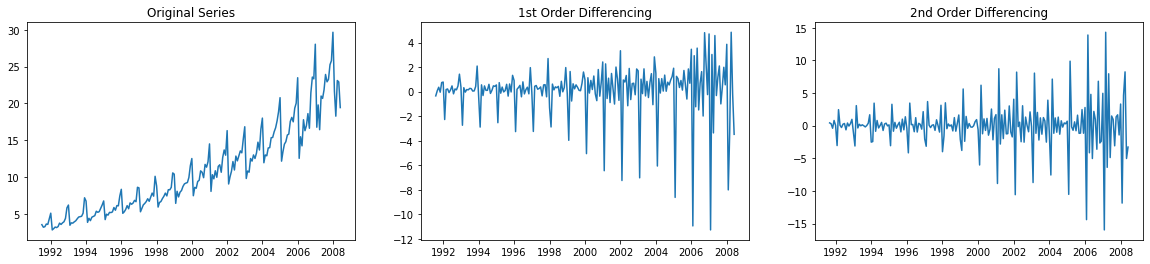

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(drugs.value); ax1.set_title('Original Series');
ax2.plot(differenced_1); ax2.set_title('1st Order Differencing');
ax3.plot(differenced_2); ax3.set_title('2nd Order Differencing');

# Deseasonalize a TS
there are different methods for deseasonalizing

- 1. Take a **moving average** with length as the seasonal window. This will smoothen in series in the process.

- 2. **Seasonal difference** the series (subtract the value of previous season from the current value)

- 3. **Divide the series by the seasonal index** obtained from STL decomposition

If dividing by the seasonal index does not work well, try taking a log of the series and then do the deseasonalizing or the other way around. You can later restore to the original scale by taking an exponential.

In [46]:
# Time Series Decomposition
result_mul = seasonal_decompose(drugs['value'], model='multiplicative', extrapolate_trend='freq')

In [47]:
# Deseasonalize
deseasonalized = drugs.value.values / result_mul.seasonal
deseason_log = np.log(drugs.value.values/result_mul.seasonal)
diff_deseason_log = deseason_log.diff().dropna()
diff_diff = deseason_log.diff().diff().dropna()

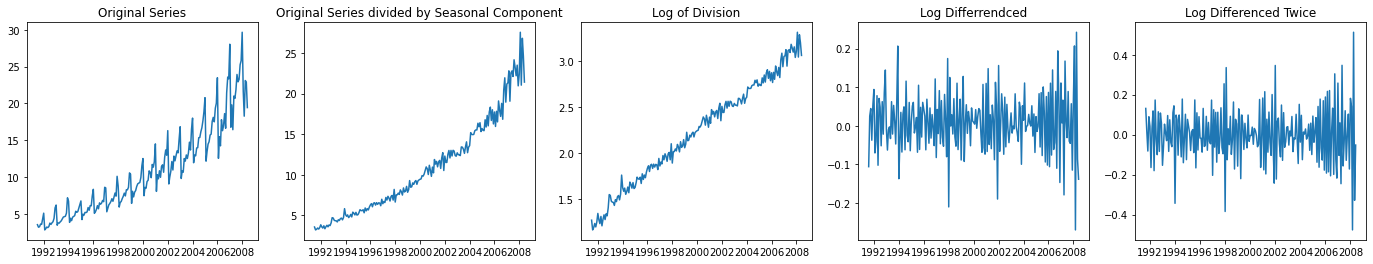

In [48]:
# Plot
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24,4))
ax1.plot(drugs.value); ax1.set_title('Original Series');
ax2.plot(deseasonalized); ax2.set_title('Original Series divided by Seasonal Component');
ax3.plot(deseason_log); ax3.set_title('Log of Division');
ax4.plot(diff_deseason_log); ax4.set_title('Log Differrendced')
ax5.plot(diff_diff); ax5.set_title('Log Differenced Twice')
plt.show()

# Test for Seasonality of a TS

The types of seasonality is determined by the clock or the calendar:</br>
Hour of day / Day of month / Weekly / Monthly / Yearly</br>

- However, if you want a more definitive inspection of the seasonality, use the Autocorrelation Function (ACF) plot.
- When there is a strong seasonal pattern, the ACF plot usually reveals definitive repeated spikes at the multiples of the seasonal window. 
- Caution is need in real word datasets b/c such strong pattern is hardly noticed and can get distorted by any noise.

> **ACF**: is simply the correlation of the series with itself</br>
> **PACF**: removes intermediary correlations

## Autocorrelation
- Autocorrelation plots are a commonly-used tool for checking randomness in a data set.
- Measures the correlation between the time series Y<sub>(t)</sub> (actual) and a lagged version of itself Y<sub>(t − i)</sub> (past values)
- ACF measures direct & indirect effects. 
- The Blue Cone represents a confidence interval (Default 95%)
- Peak inside of cone ➔ Not statistically significant - no peaks mean no seasonality
- Annual seasonality is confirmed by repetitive peaks (peaks at lag = 12)

Assumption made by ACF is that the data is weak stationary — meaning no systematic change in the mean, variance, and no systematic fluctuation.</br>
So when performing ACF it is advisable to remove any trend present in the data and to make sure the data is stationary.

- values beyond the confidence interval (blue cone) -> statistically significant. 



## Partial Autocorrelation Function (PACF)
- PACF conveys the pure correlation of a series and its lag, excluding the correlation from the intermediate lags.
- Using linear modelling, we can isolate each lag term.</br>
- This is known as Auto Regression (AR) and the analysis of lag terms is known as a **Partial Autocorrelation Function (PACF)**</br>
- We can compute the partial correlation coefficients β<sub>i</sub> of the multivariate regression. Then plot each in a PACF graph</br>

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

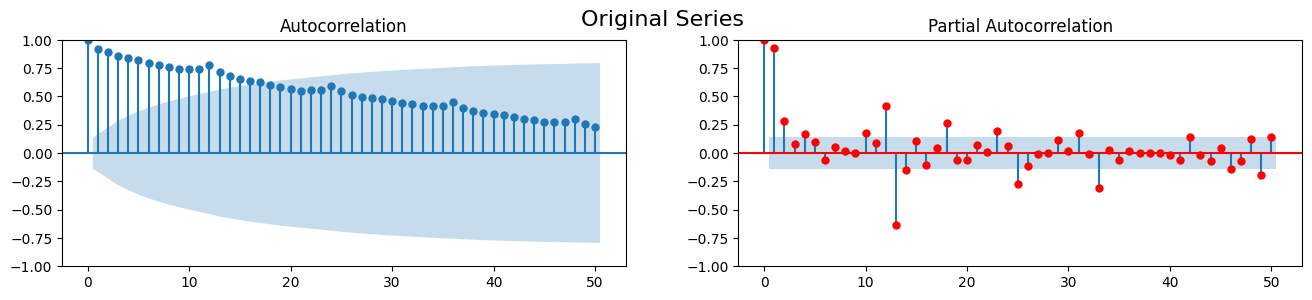

In [50]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
fig.suptitle('Original Series', fontsize=16)
plot_acf(drugs.value.tolist(), lags=50, ax=axes[0]);
plot_pacf(drugs.value.tolist(), lags=50, ax=axes[1], color='r', method='yw');

plt.show()

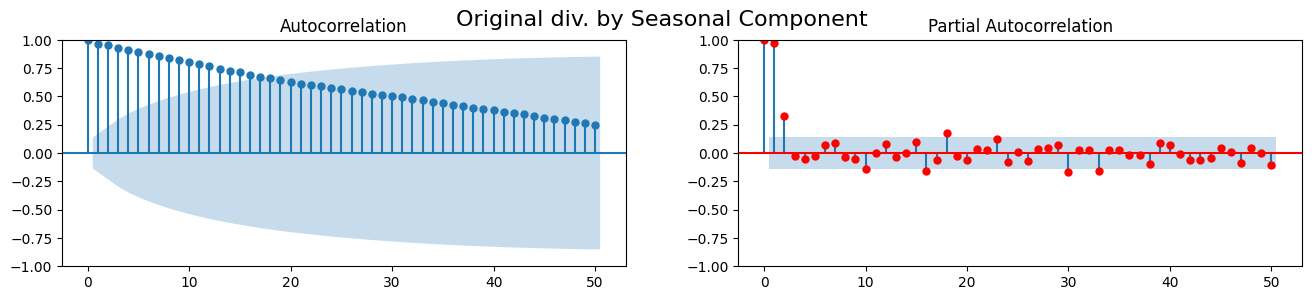

In [51]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
fig.suptitle('Original div. by Seasonal Component', fontsize=16)
plot_acf(deseasonalized.tolist(), lags=50, ax=axes[0]);
plot_pacf(deseasonalized.tolist(), lags=50, ax=axes[1], color='r', method='yw');
plt.show()

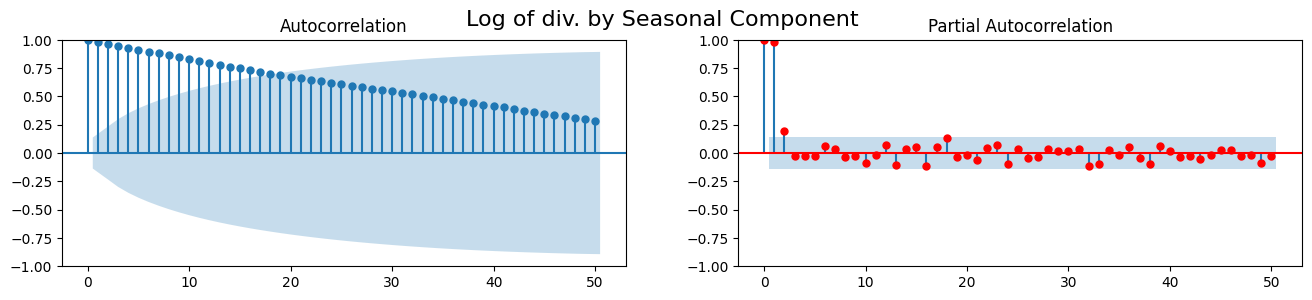

In [52]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
fig.suptitle('Log of div. by Seasonal Component', fontsize=16)
plot_acf(deseason_log.tolist(), lags=50, ax=axes[0]);
plot_pacf(deseason_log.tolist(), lags=50, ax=axes[1], color='r', method='yw');

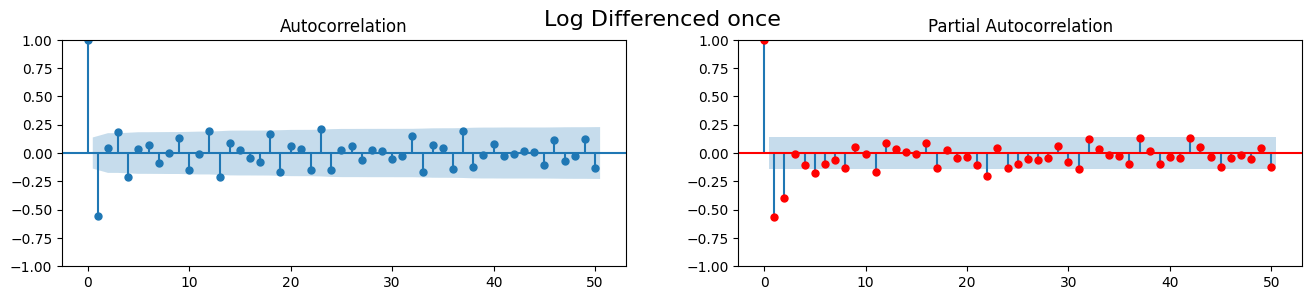

In [53]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
fig.suptitle('Log Differenced once', fontsize=16)
plot_acf(diff_deseason_log.tolist(), lags=50, ax=axes[0]);
plot_pacf(diff_deseason_log.tolist(), lags=50, ax=axes[1], color='r', method='yw');

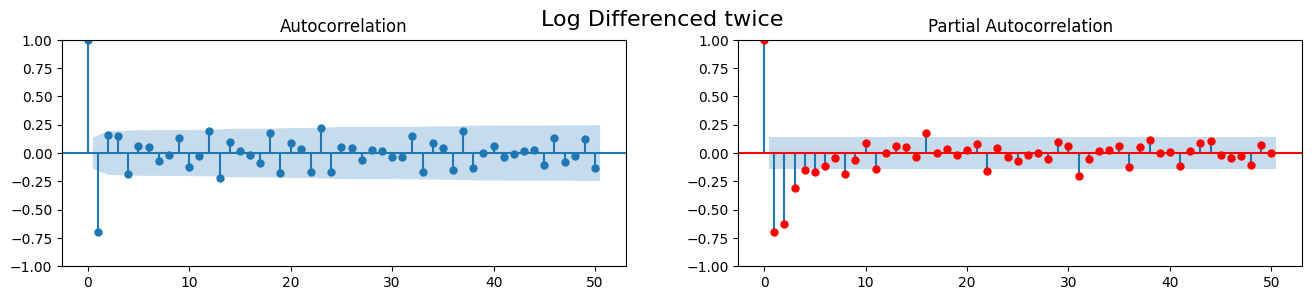

In [54]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
fig.suptitle('Log Differenced twice', fontsize=16);
plot_acf(diff_diff.tolist(), lags=50, ax=axes[0]);
plot_pacf(diff_diff.tolist(), lags=50, ax=axes[1], color='r', method='yw');

Randomness is one of the four assumptions that typically underlie all measurement processes. 
- The validity of moste statistical tests are directly linked to the validity of the randomness assumption.
- Data that has significant autocorrelation is not random. 
- But uncorrelated does not necessarily mean random -> can still exhibit non-randomness in other ways.
- If random -> autocorrelations should be near 0 for any and all time-lag separations -> observations are not correlated with one another.
- If non-random -> one or more of the autocorrelations will be significantly non-zero. -> strong positive or negative correlations between consecutive observations

## ADF Test to check for stationarity

In [55]:
from statsmodels.tsa.stattools import adfuller
print('p-value of   divided by seasonal component: ', adfuller(deseasonalized)[1]) 
print('p-value of   log (div. by season. comp):          ', adfuller(deseason_log)[1])
print('p-value of   log + diff():                                   ', adfuller(diff_deseason_log)[1])
print('p-value of   log + diff().diff():                           ', adfuller(diff_diff)[1])      

p-value of   divided by seasonal component:  1.0
p-value of   log (div. by season. comp):           0.7265344484567899
p-value of   log + diff():                                    8.541361073452953e-10
p-value of   log + diff().diff():                            1.28776046990312e-12


## ndiffs
We can also determine differencing term (i) automatically

In [56]:
from pmdarima.arima.utils import ndiffs
ndiffs(deseason_log)

1

# ARIMA - Auto Regressive Integrated Moving Average
we can combine **Autoregression (AR)** with **Differencing (I)** and **Moving Averages (MA)** to get a stationary TS
- **AR**: partial correlation with **p** number of lags 
- **I**: stands for differencing -> to reach stationarity (remove function of time) through taking the difference </br> of each lag (10,11,9,13) -> (Nan, 1, -2, 4)
- **MA**: stands for Moving Average Model - here Y<sub>t</sub> depends on the errors $\epsilon_t$ of the AR

**Hyperparameters - p, i, q**
- **p** is the number of lags to incorporate into the **AR** - we find ideal p though the partial Autocorrelation Graph (**PACF**)
- **i** refers to the times we have to difference the TS to reach stationarity - i=2 would mean we first get the difference of the shifted original series and than the difference of these differences. To see if we reached stationarity we can use teh **ADF Test**. 
- **q** is the number of lags for the **MA** model, q corresponds to the size of the window (number of past values to calculate an average) - for the ideal number q we consult the **ACF**.

**ACF / PACF - q/p**
- **p** hyperparameter for **AR** is read from **PACF** (Partial Autocorrelation Function)
- **q** for **MA** (moving average) is read from **ACF** (Autocorrelation Function)
- **i** the differencing term, can be detected visually or automatically with ndiffs.
- **p, q, i** hyperparamters can be found via **Gridsearch**

**Deseasonalize & Detrend**
- even after differencing season and trend can be apparent -> removing seasonality & trend useful
- else SARIMAX models will take car of seaonality especially

In [70]:
drugs3 = drugs.drop(columns=["year", "month"]).copy()

## Detrend, Deseasonalize & Difference

In [87]:
# remove seasonality - multiplicative seasonal component showed most useful before
drugs3["deseasonalized"] = drugs3.value.values / result_mul.seasonal

# deseasonalize by subtracting the trend component of decomposition had best results 
drugs3["detrended"] = drugs3.deseasonalized - result_mul.trend

# differencing once ofr twice removes differences in variance
drugs3["differenced_once"] = drugs3.detrended.diff()
drugs3["differenced_twice"] = drugs3.detrended.diff().diff()

# how does it look when we only difference without deseasonalizing & detrending
drugs3["original Series differenced"] = drugs3.value.diff()
drugs3["original Series differenced twice"] = drugs3.value.diff().diff()

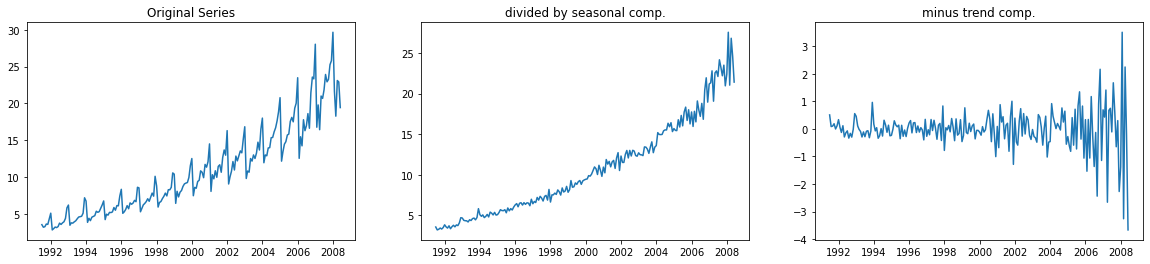

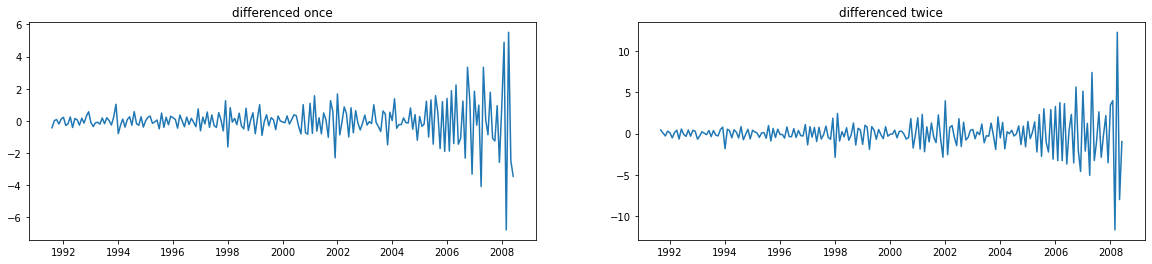

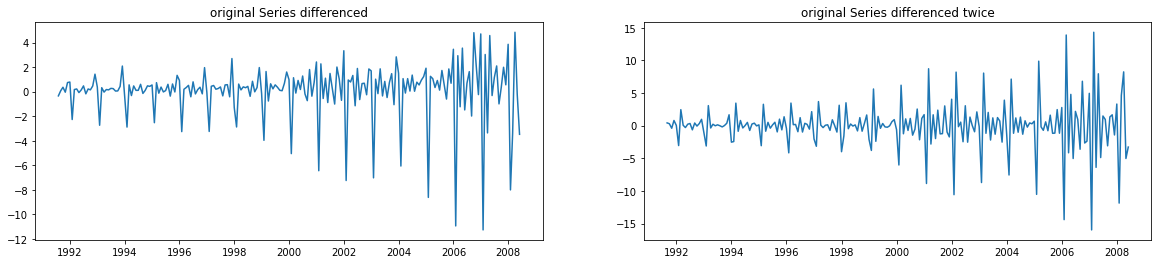

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(drugs3.value); ax1.set_title('Original Series');
ax2.plot(drugs3.deseasonalized); ax2.set_title('divided by seasonal comp.');
ax3.plot(drugs3.detrended); ax3.set_title('minus trend comp.');

# differenced after deseasonalizing and detrending
fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(20,4))
ax4.plot(drugs3.differenced_once); ax4.set_title('differenced once');
ax5.plot(drugs3.differenced_twice); ax5.set_title('differenced twice');

# differenced without deseasonalizing and detrending
fig, (ax6, ax7) = plt.subplots(1, 2, figsize=(20,4))
ax6.plot(drugs3["original Series differenced"]); ax6.set_title('original Series differenced');
ax7.plot(drugs3["original Series differenced twice"]); ax7.set_title('original Series differenced twice');

## ADF test for stationarity

In [111]:
from statsmodels.tsa.stattools import adfuller
print("deseasonalized")
print('p-value of   divided by seasonal component:                 ', adfuller(drugs3.deseasonalized)[1]) 
print("\ndeseasonalized & detrended")
print('p-value of   (div. by season. comp) - trend comp:          ', adfuller(drugs3.detrended)[1])
print("\ndeseasonalized & detrended & differenced")
print('p-value of   deseason/-trended + diff():                          ', adfuller(drugs3.differenced_once.dropna())[1])
print('p-value of   deseason/-trended + diff().diff():                  ', adfuller(drugs3.differenced_twice.dropna())[1])  
print("\njust differenced")
print('p-value of   original Series differenced:                          ', adfuller(drugs3["original Series differenced"].dropna())[1])
print('p-value of   original Series differenced twice:                 ', adfuller(drugs3["original Series differenced twice"].dropna())[1])        

deseasonalized
p-value of   divided by seasonal component:                  1.0

deseasonalized & detrended
p-value of   (div. by season. comp) - trend comp:           1.88546720805756e-08

deseasonalized & detrended & differenced
p-value of   deseason/-trended + diff():                           1.1004713912368111e-10
p-value of   deseason/-trended + diff().diff():                   7.135081084808477e-14

just differenced
p-value of   original Series differenced:                           0.11665341686468961
p-value of   original Series differenced twice:                  3.543916358529571e-18


ADF p-value near zero is enough no need to over-differenciate 

## Finding p, q with PACF & ACF

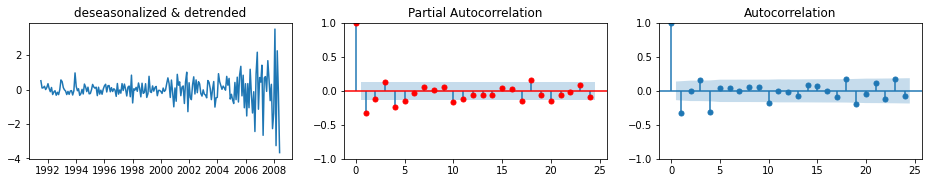

In [114]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(drugs3.detrended); axes[0].set_title('deseasonalized & detrended')
plot_pacf(drugs3.detrended, ax=axes[1], c='r', method="ywm");
plot_acf(drugs3.detrended, ax=axes[2]);

i = ?

In [115]:
from pmdarima.arima.utils import ndiffs
ndiffs(drugs3.detrended)

0

## Fit ARIMA model with identified hyperparameters
p = 2,   i = 0, q = 2

In [117]:
# The (p, i, q) order of the model for the autoregressive, differences, and moving average components.
from statsmodels.tsa.arima.model import ARIMA 
arima = ARIMA(drugs3.detrended, order=(2,0,2))
arima_fit = arima.fit()
arima_fit.summary()

/home/mz/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/mz/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/mz/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              detrended   No. Observations:                  204
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -205.263
Date:                Thu, 10 Mar 2022   AIC                            422.526
Time:                        17:05:13   BIC                            442.434
Sample:                    07-01-1991   HQIC                           430.579
                         - 06-01-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0089      0.040     -0.226      0.821      -0.087       0.069
ar.L1         -1.1249      0.052    -21.596      0.000      -1.227      -1.023
ar.L2         -0.8967      0.040    -22.462      0.000      -0.975      -0.818
ma.L1          0.8098      0.068     11.865      0.000       0.676       0.944
ma.L2          0.6839      0.068     10.037      0.000       0.550       0.817
sigma2         0.4355      0.026     16.891      0.000       0.385       0.486
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):               156.79
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):              15.52   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""